# Chicago Traffic Crashes

In [1]:
# importing necessary libraries
import pandas as pd
import numpy as np
from numpy import mean, array, count_nonzero
from scipy import stats

from sklearn.datasets import make_regression
import matplotlib.pyplot as plt
from matplotlib import ticker
%matplotlib inline

pd.options.mode.chained_assignment = None

import seaborn as sns
color = sns.color_palette()
plt.style.use('seaborn-notebook')
from yellowbrick.regressor import ResidualsPlot
import statsmodels.api as sm
from statsmodels.api import OLS
import geopandas as gpd
from shapely.geometry import Point, Polygon

from pandas_profiling import ProfileReport
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.linear_model import Ridge, LinearRegression, LogisticRegression, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, cross_validate, KFold, cross_val_score
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, OrdinalEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance
from sklearn.naive_bayes import BernoulliNB
from xgboost import XGBClassifier

from sklearn.metrics import mean_squared_error, make_scorer, r2_score, mean_absolute_error, plot_confusion_matrix
from sklearn.metrics import recall_score, accuracy_score, precision_score, f1_score, roc_curve, roc_auc_score
from sklearn.metrics import classification_report, plot_roc_curve, confusion_matrix, precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve, auc, PrecisionRecallDisplay, average_precision_score

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline
import warnings
warnings.filterwarnings("ignore")

In [2]:
# import cleaned csv
df = pd.read_csv('./data/clean_chicago.csv')
print(df.shape)
df.head()

(185109, 14)


,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,ROADWAY_SURFACE_COND,Incident with Injury,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,LOCATION,VEHICLE_TYPE,SPEED_LIMIT
0,NO TRAFFIC SIGNAL/SIGN,NO CONTROLS,CLEAR,DAYLIGHT,PARKED/FIXED,PARKING LOT,DRY,0,1-4PM,4.0,7.0,POINT (-87.766204825838 41.925892880213),PASSENGER,11 - 25
1,NO TRAFFIC SIGNAL/SIGN,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",FRONT TO FRONT/REAR,NOT DIVIDED,DRY,0,12-4 AM,1.0,8.0,POINT (-87.708608839452 41.97876270063),UNKNOWN/NA,26 - 40
2,NO TRAFFIC SIGNAL/SIGN,NO CONTROLS,CLEAR,DAYLIGHT,SIDESWIPE,NOT DIVIDED,DRY,0,1-4PM,7.0,10.0,POINT (-87.654239426731 41.764187822199),UNKNOWN/NA,11 - 25
3,NO TRAFFIC SIGNAL/SIGN,NO CONTROLS,CLEAR,DAYLIGHT,SIDESWIPE,NOT DIVIDED,DRY,0,1-4PM,7.0,10.0,POINT (-87.654239426731 41.764187822199),PASSENGER,11 - 25
4,NO TRAFFIC SIGNAL/SIGN,NO CONTROLS,CLEAR,DAYLIGHT,REAR TO FRONT/REAR/SIDE,NOT DIVIDED,DRY,0,9 AM-12 PM,2.0,8.0,POINT (-87.649918550512 41.838393259864),PASSENGER,26 - 40


In [3]:
# viewing columns, # of columns, dtypes, # of rows, # of non nulls 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185109 entries, 0 to 185108
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   TRAFFIC_CONTROL_DEVICE  185109 non-null  object 
 1   DEVICE_CONDITION        185109 non-null  object 
 2   WEATHER_CONDITION       185109 non-null  object 
 3   LIGHTING_CONDITION      185109 non-null  object 
 4   FIRST_CRASH_TYPE        185109 non-null  object 
 5   TRAFFICWAY_TYPE         185109 non-null  object 
 6   ROADWAY_SURFACE_COND    185109 non-null  object 
 7   Incident with Injury    185109 non-null  int64  
 8   CRASH_HOUR              185109 non-null  object 
 9   CRASH_DAY_OF_WEEK       185109 non-null  float64
 10  CRASH_MONTH             185109 non-null  float64
 11  LOCATION                185109 non-null  object 
 12  VEHICLE_TYPE            185109 non-null  object 
 13  SPEED_LIMIT             185109 non-null  object 
dtypes: float64(2), int64

In [4]:
# confirming dtype for one hot encoding in later pipeline 
df['CRASH_DAY_OF_WEEK'] = df['CRASH_DAY_OF_WEEK'].astype(object)
df['CRASH_MONTH'] = df['CRASH_MONTH'].astype(object)
print(df['CRASH_DAY_OF_WEEK'].dtype)
df['CRASH_MONTH'].dtype

object


dtype('O')

In [5]:
# viewing columns, # of columns, dtypes, # of rows, # of non nulls 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185109 entries, 0 to 185108
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   TRAFFIC_CONTROL_DEVICE  185109 non-null  object
 1   DEVICE_CONDITION        185109 non-null  object
 2   WEATHER_CONDITION       185109 non-null  object
 3   LIGHTING_CONDITION      185109 non-null  object
 4   FIRST_CRASH_TYPE        185109 non-null  object
 5   TRAFFICWAY_TYPE         185109 non-null  object
 6   ROADWAY_SURFACE_COND    185109 non-null  object
 7   Incident with Injury    185109 non-null  int64 
 8   CRASH_HOUR              185109 non-null  object
 9   CRASH_DAY_OF_WEEK       185109 non-null  object
 10  CRASH_MONTH             185109 non-null  object
 11  LOCATION                185109 non-null  object
 12  VEHICLE_TYPE            185109 non-null  object
 13  SPEED_LIMIT             185109 non-null  object
dtypes: int64(1), object(13)
memory usage

## Target

In [6]:
# confirming target value distribution
df['Incident with Injury'].value_counts(dropna=False, normalize=True)

0    0.843919
1    0.156081
Name: Incident with Injury, dtype: float64

##### Imbalanced classification problem involving two classes: a negative case with the majority of incidents and a positive case with a minority of incidents.

## Train-Test-Split

In [7]:
# defining X, y for train test split
X = df.drop('Incident with Injury', axis=1)
y = df['Incident with Injury']

# train test split, random state=42, test size =.25/default 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size =.25)

In [8]:
# checking X shape and null
print(X.shape)
X.isnull().sum()

(185109, 13)


TRAFFIC_CONTROL_DEVICE    0
DEVICE_CONDITION          0
WEATHER_CONDITION         0
LIGHTING_CONDITION        0
FIRST_CRASH_TYPE          0
TRAFFICWAY_TYPE           0
ROADWAY_SURFACE_COND      0
CRASH_HOUR                0
CRASH_DAY_OF_WEEK         0
CRASH_MONTH               0
LOCATION                  0
VEHICLE_TYPE              0
SPEED_LIMIT               0
dtype: int64

In [9]:
# checking y shape and nulls 
print(y.shape)
y.isnull().sum()

(185109,)


0

## Evaluation Function

In [10]:
# defining an evaluation classification function for automation and evaluating subsequent models
def evaluate_classification(model, X_train, X_test, y_train, y_test, classes=None, 
                            cmap='cividis', label=''):
    
    """Input a model, training data and test data to return sklearn metrics
        - Classification Report for training and test 
        - PR AUC Score for training and test 
        - Confusion Matrix for training and test 
        - ROC Curve for training and test
        - PR Curve for training and test
        
        Args:
        model: instantiated classifier (ex: LogisticRegression = log_reg)
        X_train: train_test_split & preprocessed
        X_test: train_test_split 
        y_train: train_test_split & preprocessed
        y_test: train_test_split 
        label: optional label for type of classifier 
        
        Modified Function, Citation:
        https://github.com/hpatel530/Chicago-Car-Crash-Data/blob/master/Chicage_Car_Crash.ipynb
    """
    # retrieve predictions for train and test data 
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # retrieve probabilites for train and test data 
    y_hat_train = model.predict_proba(X_train)
    y_hat_test = model.predict_proba(X_test)
    
    # retrieve probabilities for the positive class
    pos_probs_train = y_hat_train[:, 1]
    pos_probs_test = y_hat_test[:, 1]
    
    # print training classification report 
    header = label + " CLASSIFICATION REPORT TRAINING "
    dashes = "---" * 20
    print(dashes, header, dashes, sep='\n')
    print(classification_report(y_train, y_pred_train, target_names=classes))
    
    # calculate precision-recall area under curve
    # print training ap score
    # ap_score = average_precision_score(y_train, y_pred_train)
    # print('Training Area Under Precision-Recall Curve, measured by Average Precision score: %.3f' % ap_score)
     
    # display training figures 
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14,4))
    
    # plot confusion matrix 
    plot_confusion_matrix(model, X_train, y_train, labels=classes,
                         cmap=cmap, ax=axes[0])
    axes[0].set(title='Confusion Matrix Training')
    
    # plot ROC curve 
    plot_roc_curve(model, X_train, y_train, ax=axes[1], name=label)
    roc = axes[1]
    roc.plot([0,1], [0,1], ls=':', label='No Skill')
    roc.grid()
    roc.set_title('Receiving Operator Characteristic Training')
    
    # plot Precision-Recall curve
    PrecisionRecallDisplay.from_estimator(model, X_train, y_train, ax=axes[2], name=label)
    # y axis is Precision
    axes[2].set_ylabel('Precision')
    # x axis is Recall
    axes[2].set_xlabel('Recall')
    axes[2].set_title('Precision-Recall AUC Training')
    plt.show()

    # print testing classification report 
    header_ = label + " CLASSIFICATION REPORT TESTING "
    print(dashes, header_, dashes, sep='\n')
    print(classification_report(y_test, y_pred_test, target_names=classes))
    
    # calculate precision-recall area under curve
    # print testing ap score
    # ap_score = average_precision_score(y_test, y_pred_test)
    # print('Test Area Under Precision-Recall Curve, measured by Average Precision score: %.3f' % ap_score)
    
    # display testing figures 
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,4))
    
    # plot confusion matrix 
    plot_confusion_matrix(model, X_test, y_test, labels=classes,
                          cmap=cmap, ax=axes[0])
    axes[0].set(title='Confusion Matrix Testing')
    
    # plot ROC curve 
    plot_roc_curve(model, X_test, y_test, ax=axes[1], name=label)
    axes[1].plot([0,1], [0,1], ls=':', label='No Skill')
    axes[1].grid()
    axes[1].set_title('Receiving Operator Characteristic Test')

    # plot Precision-Recall curve
    PrecisionRecallDisplay.from_estimator(model, X_test, y_test, ax=axes[2], name=label)
    # y axis is Precision
    axes[2].set_ylabel('Precision')
    # x axis is Recall
    axes[2].set_xlabel('Recall')
    axes[2].set_title('Precision-Recall AUC Test')
    plt.legend()
    plt.show()

### Evaluation Function - Scoring Metrics
 - **Classification Report** for training and test
     - Classification Report provides several commonly used metrics
         - Precision = True Positives / (True Positives + False Positives)
             - Ability of the classifier not to label as positive a sample that is negative. 
         - Recall = True Positives / (True Positives + False Negatives)
             - Ability of the classifier to find all the positive samples.
         - F1 score = harmonic mean of the Precision and Recall
             - Popular metric for imbalanced classification, seeks to equally address precision and recall concerns. 
         - Accuracy =  True Positives / Total Predictions
             - The fraction of correct predictions.
 - **Precision-Recall AUC (Area Under Curve)** for training and test
    - The area under the precision-recall curve can be estimated by the 'average_precision_score'. AP (Average Precision) summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold, with the increase in recall from the previous threshold used as the weight. [(scikit-learn)](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html)
    - Not using the auc() function and passing the recall and precision values through it to calculate Area under the Precision-Recall Curve because it uses linear interpolation and can be too optimistic. [(scikit-learn)](https://scikit-learn.org/stable/modules/model_evaluation.html) 
    - "*When dealing with highly skewed datasets, Precision-Recall Curves provide a more informative picture of an algorithm's performance.*"  [(Davis & Goadrich, 2006)](https://www.biostat.wisc.edu/~page/rocpr.pdf)

### Evaluation Function - Display Figures
 - **Confusion Matrix** for training and test
     - Confusion matrix provides insight into which classes are being predicted correctly, which incorrectly, and what type of errors are being made. [(Brownlee, 2020)](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-imbalanced-classification/)
     - Our imbalanced classification problem lends itself to the simplest confusion matrix with two classes: majority class has the negative outcome, as "incident with no injury" (class 0) and the minority class has the positive outcome, as "incident with injury" (class 1).
     - The cells in the matrix define the metrics that make up the ROC curve and the precision-recall curve. [(Brownlee)](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-imbalanced-classification/)
 - **ROC (Receiving Operator Characteristic) Curve** for training and test
     - ROC Curve plots provide an AUC (Area Under Curve) score that summarizes the performance of a model on the positive class and can be used to compare classifiers. [(Brownlee)](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-imbalanced-classification/)
     - The x-axis indicates the False Positive Rate, the y-axis indicates the True Positive Rate. A classifier with no skill will achieve the lowest score of approximately 0.5 and 1.0 for a perfect classifier. [(Brownlee)](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-imbalanced-classification/)
     - "A popular diagnostic tool for classifiers on balanced and imbalanced binary prediction problems alike because it is not biased to the majority or minority class." [(Brownlee)](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-imbalanced-classification/)
 - **Precision-Recall Curve** for training and test
     - Precision-Recall Curves also help in the interpretation of binary classification predictive models. It plots the precision (y-axis) and the recall (x-axis) for different probability thresholds. Precision and Recall are focused on the positive class (the minority class) and are unconcerned with the true negatives (majority class). [(Brownlee)](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-imbalanced-classification/)
     - The Precision-Recall Curve plot also provides an AP (Average Precision) score that summarizes the PR curve into a single metric as the weighted mean of the precision achieved at each threshold value, and can be used to compare classifiers. [(scikit-learn)](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.PrecisionRecallDisplay.html#sklearn.metrics.PrecisionRecallDisplay.from_estimator)
     - A model with perfect skill is depicted at coordinate (1,1). A skillful model is represented by a curve that bows towards coordinate (1,1). A no-skill classifier will be a horizontal line on the plot with a precision that is proportional to the number of positive examples in the dataset. [(Brownlee)](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-imbalanced-classification/)  

### Grid Search Parameters

`# exhaustive search over specified parameter values for a classifier`<br>
`GridSearchCV(# instantiated classifier`<br>
              `model,`<br>
              `# 'params' will be a specified hyperparameter dictonary`<br>
              `param_grid = params,`<br>
              `# crossvalidation strategy set to repeat Stratified K-Fold 3 times with 10 folds`<br>
              `cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42),`<br>
              `# set to -1, all CPUs are used`<br>
              `n_jobs=-1,`<br>
              `# scoring object set to `[metrics.average_precision_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html#sklearn.metrics.average_precision_score) `as` ['average_precision'](https://scikit-learn.org/stable/modules/model_evaluation.html)`.`<br>
              `scoring='average_precision',`<br>
              `# set to 1-3 for more information`<br>
              `verbose=1)`
<br>
<br>

## Preprocessing

In [11]:
# categorical mini-pipeline for columntransformer. X, X_train, X_test have no numeric dtypes. 
# will return sparse matrix where each column corresponds to one possible value of one feature, default parameter
subpipe_cat = Pipeline(steps=[
    ('ohe', OneHotEncoder(sparse=True, handle_unknown='ignore'))
])


**Pipelines will include columntransformer ('CT') to take care of preprocessing & adding data back into original dataset**


In [12]:
# creating columntransformer as 'CT'
# columntransformer will one hot encode all non np.number dtypes
# remainder data will pass through without transformation, instead of being dropped
CT = ColumnTransformer(transformers=[
     ('subpipe_cat', subpipe_cat, make_column_selector(dtype_exclude=np.number))], remainder='passthrough')

<br>

## Models

### Dummy Model
Starting with a Dummy Classifier to serve as a simple baseline to compare against other more
complex classifiers.

In [24]:
# pipeline will preprocess data and instantiate estimator
dummy_model_pipe = Pipeline(steps=[
    ('ct', CT),
    ('dum', DummyClassifier(strategy='most_frequent'))
])

In [25]:
# fit pipeline to training data
dummy_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc5a9830130>)])),
                ('dum', DummyClassifier(strategy='most_frequent'))])

------------------------------------------------------------
Dummy Model CLASSIFICATION REPORT TRAINING 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.84      1.00      0.92    117104
           1       0.00      0.00      0.00     21727

    accuracy                           0.84    138831
   macro avg       0.42      0.50      0.46    138831
weighted avg       0.71      0.84      0.77    138831



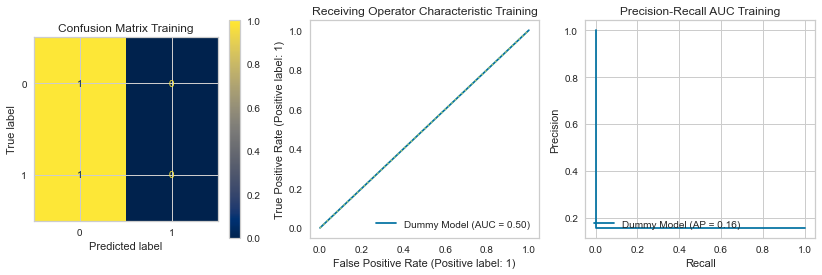

------------------------------------------------------------
Dummy Model CLASSIFICATION REPORT TESTING 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.85      1.00      0.92     39113
           1       0.00      0.00      0.00      7165

    accuracy                           0.85     46278
   macro avg       0.42      0.50      0.46     46278
weighted avg       0.71      0.85      0.77     46278



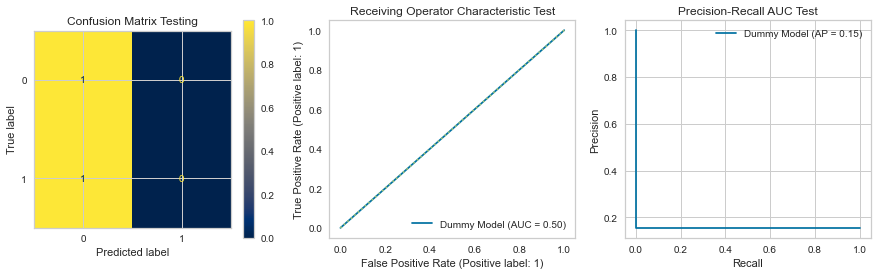

In [26]:
# classification report using function 
evaluate_classification(dummy_model_pipe,
                        X_train, 
                        X_test, 
                        y_train, 
                        y_test, 
                        label='Dummy Model')

In [27]:
print('Raw Counts')
print(df['Incident with Injury'].value_counts())
print()
print('Percentages')
print(df['Incident with Injury'].value_counts(normalize=True))

Raw Counts
0    156217
1     28892
Name: Incident with Injury, dtype: int64

Percentages
0    0.843919
1    0.156081
Name: Incident with Injury, dtype: float64


> As predicted, this dummy baseline model that always selects the majority class has an accuracy of 84%. 
The 84% accuracy matches the target's majority class percentage. The ROC AUC score shows the model has no skill at .50. The AP score shows the model has no skill with a precision that is proportional to the number of positive examples in the dataset.

### Logistic Regression

#### Simple Model
Logistic Regression serves as another simple, interpretable baseline model.

In [28]:
# pipeline will preprocess data and instantiate estimator
logreg_model = Pipeline(steps=[
    ('ct', CT),
    ('logreg', LogisticRegression(random_state=42))
])

In [29]:
# fit pipeline to training data
logreg_model.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc5a9830130>)])),
                ('logreg', LogisticRegression(random_state=42))])

------------------------------------------------------------
Logistic Regression Model CLASSIFICATION REPORT TRAINING 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.99      0.93    117104
           1       0.81      0.25      0.39     21727

    accuracy                           0.87    138831
   macro avg       0.84      0.62      0.66    138831
weighted avg       0.87      0.87      0.84    138831



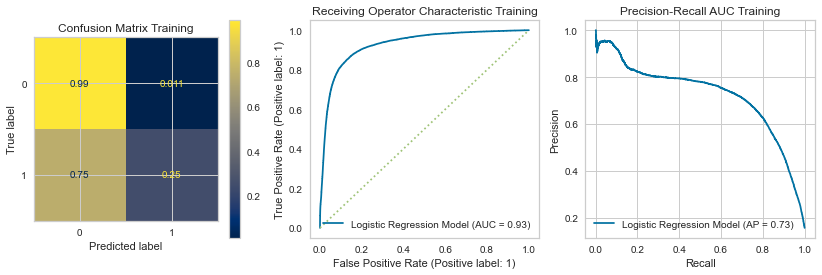

------------------------------------------------------------
Logistic Regression Model CLASSIFICATION REPORT TESTING 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.87      0.99      0.92     39113
           1       0.71      0.19      0.30      7165

    accuracy                           0.86     46278
   macro avg       0.79      0.59      0.61     46278
weighted avg       0.84      0.86      0.83     46278



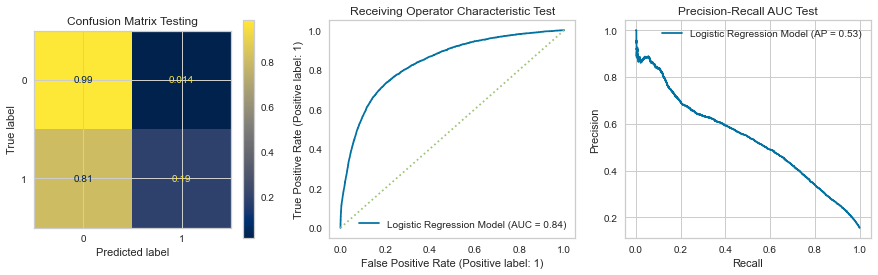

In [30]:
# classification report using function 
evaluate_classification(logreg_model,
                        X_train, 
                        X_test, 
                        y_train, 
                        y_test, 
                        label='Logistic Regression Model')

> The simple logistic regression model performed with higher accuracy, f1-score, and ROC AUC than the dummy baseline. However, while we will take note of the other metrics, we will be focusing on the metric: **AP (Average Precision)**, which calculates the area under precision-recall curve and is represented in the third plot.

> When comparing the AP metric, the simple logistic regression model performed better on the test data than the dummy model. However, with an AP at 53% it is still a poor performing model. 

A simple logistic regression model does not support imbalanced classification problems, we will need to modify the parameters of the model to factor in the target's imbalanced distribution. [(Brownlee, 2020)](https://machinelearningmastery.com/cost-sensitive-logistic-regression/)

### Grid Search
A grid search is implemented to identify the best parameters.

No critical parameters to modify. Will modify the parameters highlighted by [Machine Learning Mastery](https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/) as possibly helpful. 

In [31]:
# specified dictionary with parameter names as keys and lists of parameter settings to try as values
params = {}
params['logreg__C'] = [100, 10, 1.0, 0.1, 0.01]
params['logreg__penalty'] = ['none','l1','l2','elasticnet']

In [32]:
# create grid search over specified parameter values for classifier 
gs = GridSearchCV(logreg_model, 
                  params, 
                  cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42),
                  n_jobs=-1,
                  scoring='average_precision', 
                  verbose=3)

In [33]:
# fit grid search on train data
gs.fit(X_train, y_train)

Fitting 30 folds for each of 20 candidates, totalling 600 fits


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=10, random_state=42),
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('subpipe_cat',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fc5a9830130>)])),
                                       ('logreg',
                                        LogisticRegression(random_state=42))]),
             n_jobs=-1,
             param_grid={'logreg__C': [100, 10, 1.0, 0.1, 0.01],
                         'logreg__penalty': ['none', 'l1', 'l2', 'elasticnet']},
             scoring='average_precision', verbose=3)

In [34]:
# attribute reveals the parameter settings that produced the best results
gs.best_params_

{'logreg__C': 10, 'logreg__penalty': 'l2'}

In [35]:
# pipeline will preprocess data and instantiate estimator with grid search best parameters
logreg_gs = Pipeline(steps=[
    ('ct', CT),
    ('logreg', LogisticRegression(random_state=42, 
                                  C=10, 
                                  penalty='l2'))
])

In [36]:
# fit modified pipeline to training data
logreg_gs.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc5a9830130>)])),
                ('logreg', LogisticRegression(C=10, random_state=42))])

------------------------------------------------------------
Logistic Regression Grid Search CLASSIFICATION REPORT TRAINING 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.97      0.95    117104
           1       0.81      0.58      0.68     21727

    accuracy                           0.91    138831
   macro avg       0.87      0.78      0.81    138831
weighted avg       0.91      0.91      0.91    138831



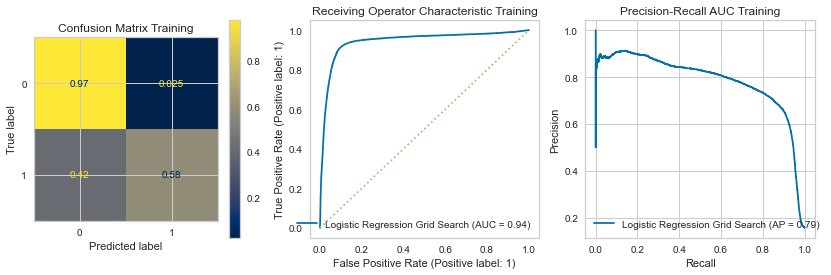

------------------------------------------------------------
Logistic Regression Grid Search CLASSIFICATION REPORT TESTING 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.97      0.92     39113
           1       0.63      0.31      0.42      7165

    accuracy                           0.86     46278
   macro avg       0.76      0.64      0.67     46278
weighted avg       0.85      0.86      0.85     46278



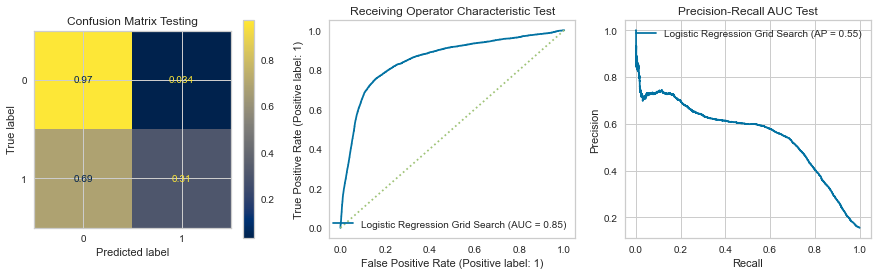

In [37]:
# classification report using function 
evaluate_classification(logreg_gs,
                        X_train, 
                        X_test, 
                        y_train, 
                        y_test, 
                        label='Logistic Regression Grid Search')

> The modified logistic regression model performed with higher f1-score, and slightly higher ROC AUC than the simple logistic regression and dummy baseline.


> When comparing the AP metric, the modified logistic regression model performed slightly better on the test data than the dummy model. However, with an AP at 55% it is still a poor performing model. 

### Weighted Grid Search

A weighted logistic regression can perform better on imbalanced classification problems. The weighting can penalize the model less for errors made on examples from the majority class and penalize the model more for errors made on examples from the minority class. [(Brownlee, 2020)](https://machinelearningmastery.com/cost-sensitive-logistic-regression/) We will perform a grid search to reveal best class weight configuration.

In [38]:
# pipeline will preprocess data and instantiate estimator with grid search best parameters from previous model 
logreg_gs = Pipeline(steps=[
    ('ct', CT),
    ('logreg', LogisticRegression(random_state=42, 
                                  C=10, 
                                  penalty='l2'))
])

In [39]:
# class weight parameter dictionary
params = {}
params['logreg__class_weight'] = [{0:100,1:1}, {0:10,1:1}, {0:1,1:1}, {0:1,1:10}, {0:1,1:100}]

In [40]:
# create grid search over specified parameter values for classifier
gs = GridSearchCV(logreg_gs, 
                  params, 
                  cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42),
                  n_jobs=-1,
                  scoring='average_precision',
                  verbose=1)

In [41]:
# execute the grid search
grid_result = gs.fit(X_train, y_train)

Fitting 30 folds for each of 5 candidates, totalling 150 fits


In [42]:
# attribute reveals the parameter settings that produced the best results
grid_result.best_params_

{'logreg__class_weight': {0: 10, 1: 1}}

In [43]:
# pipeline will preprocess data and instantiate estimator with grid search best parameters
weighted_logreg = Pipeline(steps=[
    ('ct', CT),
    ('logreg', LogisticRegression(random_state=42, 
                                  C=10, 
                                  penalty='l2',
                                  class_weight={0: 10, 1: 1}
                                 ))
])

In [44]:
# fit modified pipeline to training data
weighted_logreg.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc5a9830130>)])),
                ('logreg',
                 LogisticRegression(C=10, class_weight={0: 10, 1: 1},
                                    random_state=42))])

------------------------------------------------------------
Weighted Logistic Regression CLASSIFICATION REPORT TRAINING 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.87      1.00      0.93    117104
           1       0.96      0.21      0.35     21727

    accuracy                           0.88    138831
   macro avg       0.92      0.60      0.64    138831
weighted avg       0.89      0.88      0.84    138831



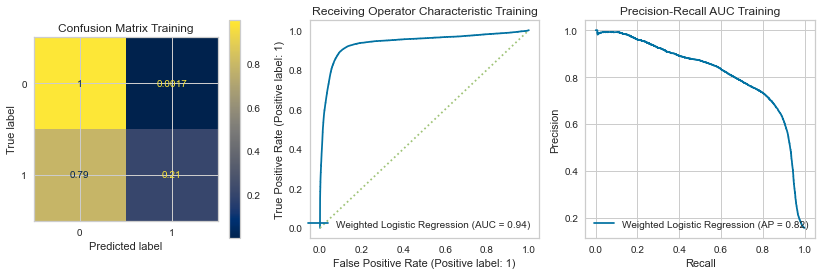

------------------------------------------------------------
Weighted Logistic Regression CLASSIFICATION REPORT TESTING 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.86      0.99      0.92     39113
           1       0.79      0.14      0.24      7165

    accuracy                           0.86     46278
   macro avg       0.83      0.57      0.58     46278
weighted avg       0.85      0.86      0.82     46278



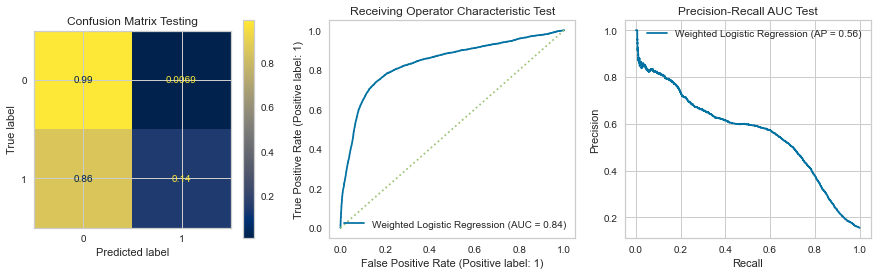

In [45]:
# classification report using function 
evaluate_classification(weighted_logreg,
                        X_train, 
                        X_test, 
                        y_train, 
                        y_test, 
                        label='Weighted Logistic Regression')

> The weighted logistic regression model performed with lower accuracy, f1-score, and ROC AUC than the other logistic regression models. 


> When comparing the AP metric, the weighted logistic regression model performed better on the test data than the other logistic regression models. However, with an AP at 56%, it is still a poor performing model.

We were not able to get a decent AP score using the logistic regression classifier, the next iteration will be a more complex classifier. 

### Decision Tree

#### Simple Model
Decision trees are an effective model for binary classification problems. [(Brownlee, 2020)](https://machinelearningmastery.com/cost-sensitive-decision-trees-for-imbalanced-classification/) A decision tree model emphasizes learning the relationship between the features and the target. Decision trees look for ways to split the data based on features to decrease the entropy of the target in each split. [(Nonparametric Models Lab, 2022)](https://github.com/brdeleon/dsc-nonparametric-models-lab/blob/master/index.ipynb)

In [15]:
# pipeline will preprocess data and instantiate estimator
dt_model = Pipeline(steps=[
    ('ct', CT),
    ('dtc', DecisionTreeClassifier(random_state=42))
])

In [ ]:
# fit pipeline to training data
dt_model.fit(X_train,y_train)

------------------------------------------------------------
Decision Tree CLASSIFICATION REPORT TRAINING 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    117104
           1       1.00      1.00      1.00     21727

    accuracy                           1.00    138831
   macro avg       1.00      1.00      1.00    138831
weighted avg       1.00      1.00      1.00    138831



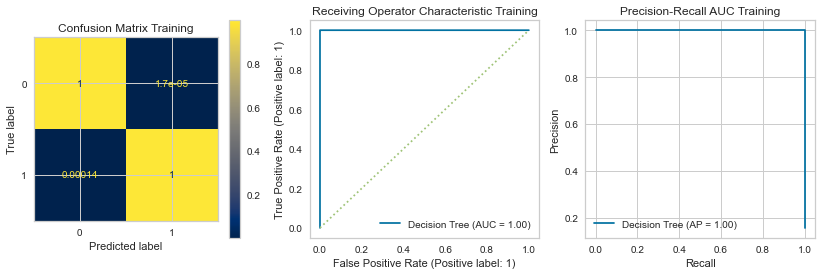

------------------------------------------------------------
Decision Tree CLASSIFICATION REPORT TESTING 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     39113
           1       0.91      0.73      0.81      7165

    accuracy                           0.95     46278
   macro avg       0.93      0.86      0.89     46278
weighted avg       0.94      0.95      0.94     46278



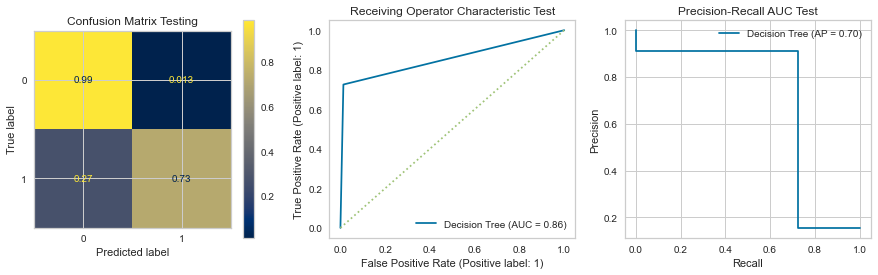

In [48]:
# classification report using function
evaluate_classification(dt_model,
                        X_train, 
                        X_test, 
                        y_train, 
                        y_test, 
                        label='Decision Tree')

> This simple decision tree classifier performs better across all metrics on the test data than all of the other models. We reached an AP score of: 70%. 
<br>

A simple decision tree classifier is not usually best for imbalanced classification problems, we should modify the parameters of the model to factor in the target's imbalanced distribution. [(Brownlee, 2020)](https://machinelearningmastery.com/cost-sensitive-decision-trees-for-imbalanced-classification/)

### Grid Search
The decision tree classifier can perform better on imbalanced classification problems by modifying the criterion used to evaluate split points so that it is weighted by and takes into account the importance of each class. [(Brownlee, 2020)](https://machinelearningmastery.com/cost-sensitive-decision-trees-for-imbalanced-classification/) We will grid search a range of different class weight configurations and discover which results in the best AP score.

In [16]:
# class weight parameter dictionary
params = {}
params['dtc__class_weight'] = [{0:100,1:1}, {0:10,1:1}, {0:1,1:1}, {0:1,1:10}, {0:1,1:100}]

In [17]:
# create grid search over specified parameter values for classifier 
gs = GridSearchCV(dt_model, 
                  params, 
                  cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42),
                  n_jobs=-1,
                  scoring='recall',
                  verbose=1)

In [18]:
# fit grid search on train data
gs.fit(X_train, y_train)

Fitting 30 folds for each of 5 candidates, totalling 150 fits


KeyboardInterrupt: 

In [ ]:
# attribute reveals the parameter settings that produced the best results
gs.best_params_

In [ ]:
# classification report using function 
evaluate_classification(gs,
                        X_train, 
                        X_test, 
                        y_train, 
                        y_test, 
                        label='Decision Tree GS')

In [15]:
# pipeline will preprocess data and instantiate estimator with grid search best parameters
weighted_dt = Pipeline(steps=[
    ('ct',CT),
    ('dtc',DecisionTreeClassifier(random_state=42, 
                                   class_weight={0: 1, 1: 1}))
])

In [16]:
# fit modified pipeline to training data
weighted_dt.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc8606d1700>)])),
                ('dtc',
                 DecisionTreeClassifier(class_weight={0: 1, 1: 1},
                                        random_state=42))])

------------------------------------------------------------
Weighted Decision Tree CLASSIFICATION REPORT TRAINING 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    117104
           1       1.00      1.00      1.00     21727

    accuracy                           1.00    138831
   macro avg       1.00      1.00      1.00    138831
weighted avg       1.00      1.00      1.00    138831



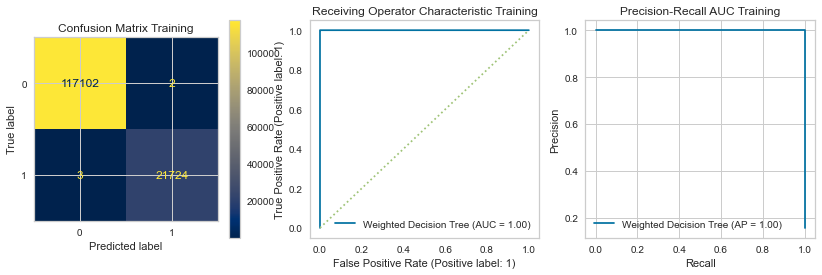

------------------------------------------------------------
Weighted Decision Tree CLASSIFICATION REPORT TESTING 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     39113
           1       0.91      0.73      0.81      7165

    accuracy                           0.95     46278
   macro avg       0.93      0.86      0.89     46278
weighted avg       0.94      0.95      0.94     46278



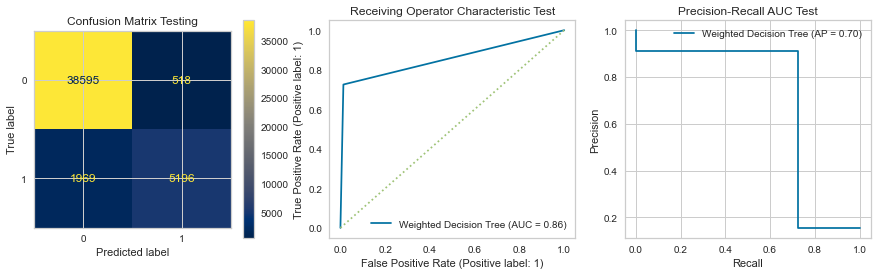

In [17]:
# classification report using function 
evaluate_classification(weighted_dt,
                        X_train, 
                        X_test, 
                        y_train, 
                        y_test, 
                        label='Weighted Decision Tree')

> The weighted decision tree did not perform better than the simple decision tree model across any metrics. They resulted in the same scores. 

For the next iteration, we will move on to an ensemble classifier that is based on randomized decision tree classifiers.  

### Random Forest

#### Simple Model
Ensemble classifiers can produce better predictive performace because they combine the predictions of several models. <br>
<br>
Random Forest Classifier uses the averaging ensemble method; it builds several independent models and averages their predictions. [(scikit-learn)](https://scikit-learn.org/stable/modules/ensemble.html)

In [56]:
# pipeline will preprocess data and instantiate estimator
rfc_model = Pipeline(steps=[
    ('ct',CT),
    ('rfc',RandomForestClassifier(random_state=42))
])

In [57]:
# fit pipeline to training data
rfc_model.fit(X_train,y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc5a9830130>)])),
                ('rfc', RandomForestClassifier(random_state=42))])

------------------------------------------------------------
Random Forest CLASSIFICATION REPORT TRAINING 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    117104
           1       1.00      1.00      1.00     21727

    accuracy                           1.00    138831
   macro avg       1.00      1.00      1.00    138831
weighted avg       1.00      1.00      1.00    138831



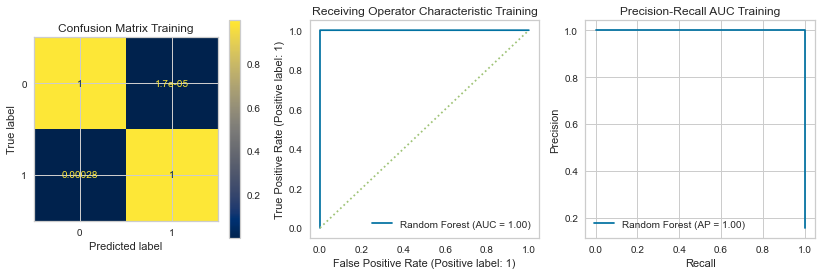

------------------------------------------------------------
Random Forest CLASSIFICATION REPORT TESTING 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      1.00      0.96     39113
           1       0.96      0.57      0.71      7165

    accuracy                           0.93     46278
   macro avg       0.94      0.78      0.84     46278
weighted avg       0.93      0.93      0.92     46278



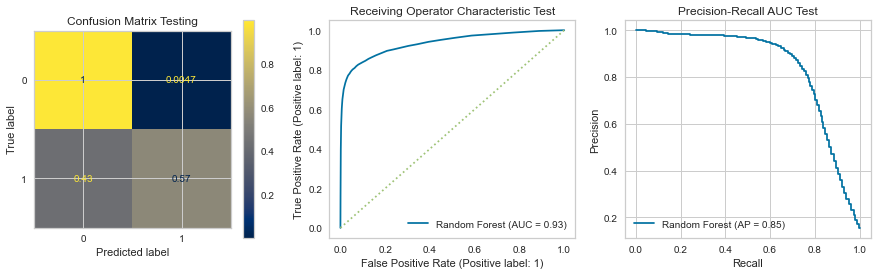

In [58]:
# classification report using function
evaluate_classification(rfc_model,
                        X_train, 
                        X_test, 
                        y_train, 
                        y_test, 
                        label='Random Forest')

> The simple random forest model performed lower in accuracy and f1-score. However, it performed better in both the ROC AUC at: 94% and the AP score at: 85%.


> As of here in our workflow, the simple random forest model is the best performing model.

We will modify the parameters to see if we can get a higher AP score. 

### Grid Search
We are setting the grid search to focus on the most important parameter: 'max_features', it sets the number of features to sample at each split point. [(Brownlee, 2020)](https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/)

In [59]:
# if 'sqrt', then max_features=sqrt(n_features), if 'log2', then max_features=log2(n_features), default='sqrt': 
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
params = {}
params['rfc__max_features'] = ['log2', 'sqrt']

In [60]:
# create grid search over specified parameter values for classifier
gs = GridSearchCV(rfc_model,
                   params, 
                   cv= RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42),
                   n_jobs=-1,
                   scoring='average_precision',
                   verbose=1)

In [61]:
# fit grid search on train data
gs.fit(X_train, y_train)

Fitting 30 folds for each of 2 candidates, totalling 60 fits


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=10, random_state=42),
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('subpipe_cat',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fc5a9830130>)])),
                                       ('rfc',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1, param_grid={'rfc__max_features': ['log2', 'sqrt']},
             scoring='average_precision', verbose=1)

In [62]:
# attribute reveals the parameter settings that produced the best results
gs.best_params_

{'rfc__max_features': 'sqrt'}

In [63]:
# pipeline will preprocess data and instantiate estimator with grid search best parameters
rf_gs = Pipeline(steps=[
    ('ct',CT),
    ('rfc',RandomForestClassifier(random_state=42, 
                                   max_features='sqrt'
                                 ))
])

In [64]:
# fit modified pipeline to training data
rf_gs.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc5a9830130>)])),
                ('rfc', RandomForestClassifier(random_state=42))])

------------------------------------------------------------
Random Forest CLASSIFICATION REPORT TRAINING 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    117104
           1       1.00      1.00      1.00     21727

    accuracy                           1.00    138831
   macro avg       1.00      1.00      1.00    138831
weighted avg       1.00      1.00      1.00    138831



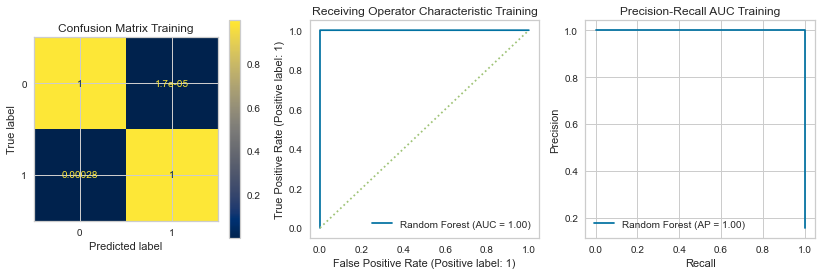

------------------------------------------------------------
Random Forest CLASSIFICATION REPORT TESTING 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      1.00      0.96     39113
           1       0.96      0.57      0.71      7165

    accuracy                           0.93     46278
   macro avg       0.94      0.78      0.84     46278
weighted avg       0.93      0.93      0.92     46278



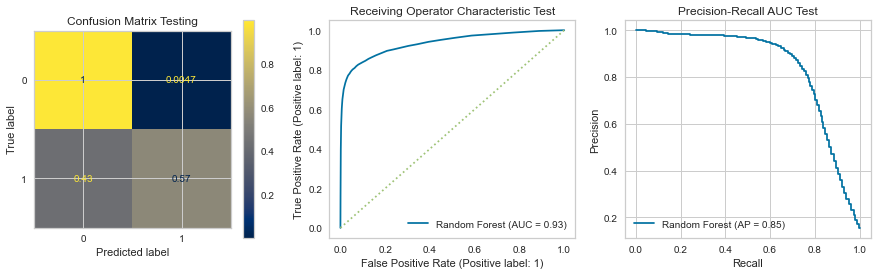

In [65]:
# classification report using function
evaluate_classification(rf_gs,
                        X_train, 
                        X_test, 
                        y_train, 
                        y_test, 
                        label='Random Forest')

> The best params result was already the default parameter setting. We are not expecting significantly different scores. 


> The most recent instantiation of random forest performed with the same scores all across, as expected.


> The random forest model with default parameters remains the best performing model with an AP score of: 85%. 

We will try another top classifier.

### Gradient Booster

#### Simple Model
Gradient Boosting Classifier supports binary classification and is built upon decision trees. 

Gradient Boosting Classifier uses the boosting ensemble method; it creates a powerful ensemble of sequentially built weaker tree models. [(scikit-learn)](https://scikit-learn.org/stable/modules/ensemble.html)

In [66]:
# pipeline will preprocess data and instantiate estimator
gbc_model = Pipeline(steps=[
    ('ct', CT), 
    ('gbc', GradientBoostingClassifier(random_state=42))
])

In [67]:
# fit pipeline to training data
gbc_model.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc5a9830130>)])),
                ('gbc', GradientBoostingClassifier(random_state=42))])

------------------------------------------------------------
Gradient Tree Boosting CLASSIFICATION REPORT TRAINING 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.86      1.00      0.92    117104
           1       0.83      0.12      0.22     21727

    accuracy                           0.86    138831
   macro avg       0.85      0.56      0.57    138831
weighted avg       0.86      0.86      0.81    138831



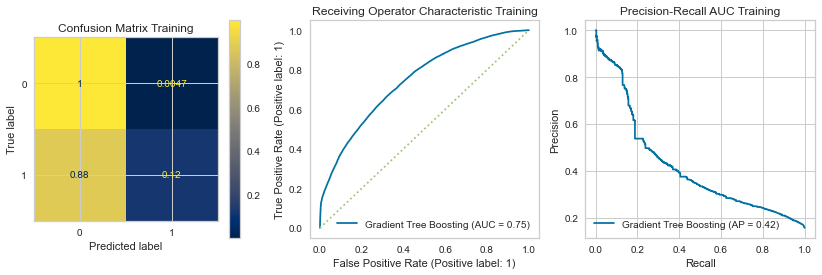

------------------------------------------------------------
Gradient Tree Boosting CLASSIFICATION REPORT TESTING 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.86      1.00      0.92     39113
           1       0.84      0.12      0.21      7165

    accuracy                           0.86     46278
   macro avg       0.85      0.56      0.57     46278
weighted avg       0.86      0.86      0.81     46278



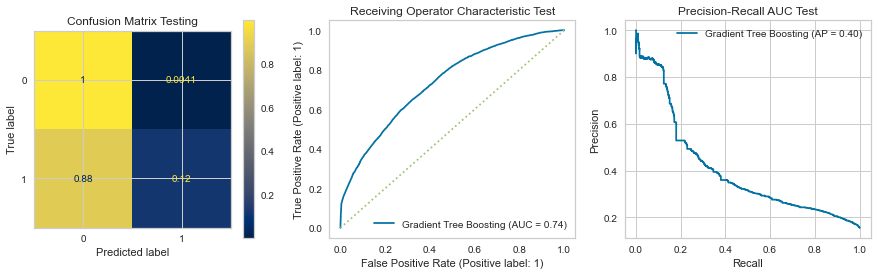

In [68]:
# classification report using function
evaluate_classification(gbc_model,
                        X_train, 
                        X_test, 
                        y_train, 
                        y_test, 
                        label='Gradient Tree Boosting')

> Gradient tree boosting did not produce any high performance metrics. 


> It performed poorly with an AP score of 40%.

We will move forward with the random forest classifier and attempt to get a higher AP score by adding SMOTE.  

### SMOTE

SMOTE is likely the most popular method for data oversampling. An imbalanced classification problem can benefit from data oversampling because it involves duplicating examples of the minority class or synthesizing new examples from the minority class from existing examples. [(Brownlee, 2020)](https://machinelearningmastery.com/framework-for-imbalanced-classification-projects/)<br>
An imblearn pipeline is able to support the SMOTE method.

In [69]:
# imbpipe will preprocess data, smote, and instantiate the best performing estimator
imb_pipe = ImPipeline(steps=[
    ('ct',CT),
    ('sm',SMOTE(random_state=42)),
    ('rfc',RandomForestClassifier(random_state=42, 
                                   max_features='sqrt'
                                 ))
])

In [70]:
# fit pipeline to training data
imb_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc5a9830130>)])),
                ('sm', SMOTE(random_state=42)),
                ('rfc', RandomForestClassifier(random_state=42))])

------------------------------------------------------------
Random Forest SMOTE CLASSIFICATION REPORT TRAINING 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    117104
           1       1.00      1.00      1.00     21727

    accuracy                           1.00    138831
   macro avg       1.00      1.00      1.00    138831
weighted avg       1.00      1.00      1.00    138831



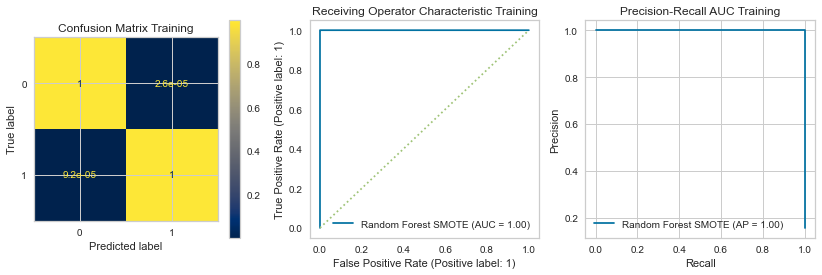

------------------------------------------------------------
Random Forest SMOTE CLASSIFICATION REPORT TESTING 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.92      0.99      0.96     39113
           1       0.93      0.56      0.70      7165

    accuracy                           0.92     46278
   macro avg       0.93      0.77      0.83     46278
weighted avg       0.92      0.92      0.92     46278



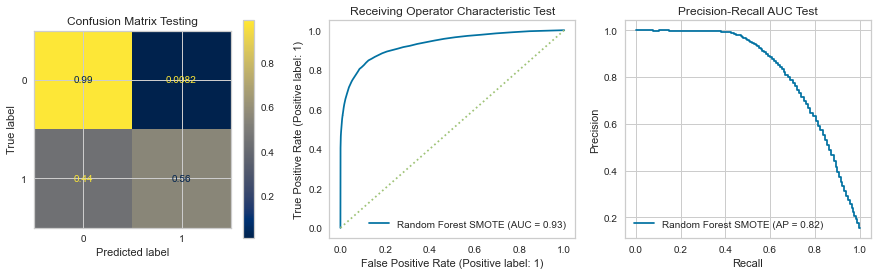

In [71]:
# classification report using function
evaluate_classification(imb_pipe, 
                        X_train, 
                        X_test, 
                        y_train, 
                        y_test, 
                        label='Random Forest SMOTE')

> The random forest classifier with SMOTE performed well.
However, we will move forward with the random forest classifier with default parameters as it remains the best performing model with an AP score of: 85%. 

## Classification Metric

Metric used to evaluate best model performance: [AP (Average Precision) score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html#sklearn.metrics.average_precision_score)

The selection of AP (Average Precision) score as the most appropriate classification metric was informed by data exploration and the business problem itself. 
 - Precision-Recall Curves help in the interpretation of binary classification predictive models. 
 - The area under the precision-recall curve can be estimated by the 'average_precision_score': AP (Average Precision).
 - The Precision-Recall Curve plot provides an AP (Average Precision) score that summarizes the Precision-Recall curve into a single metric: as the weighted mean of the precision achieved at each threshold value, and it can be used to compare classifiers. [(scikit-learn)](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.PrecisionRecallDisplay.html#sklearn.metrics.PrecisionRecallDisplay.from_estimator)

**The focus of the Precision-Recall curve on the minority positive class made the AP (Average Precision) metric, *which summarizes the Area Under the Precision-Recall Curve*, an effective metric for our imbalanced binary classification problem.**

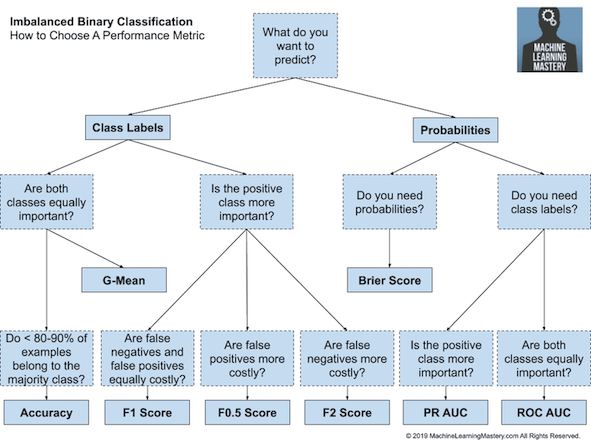

In [ ]:
# F1 score metric 
# alternative metrics to reference recall macro, AP, roc auc, 

## Final Model

------------------------------------------------------------
Random Forest CLASSIFICATION REPORT TRAINING 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    117104
           1       1.00      1.00      1.00     21727

    accuracy                           1.00    138831
   macro avg       1.00      1.00      1.00    138831
weighted avg       1.00      1.00      1.00    138831



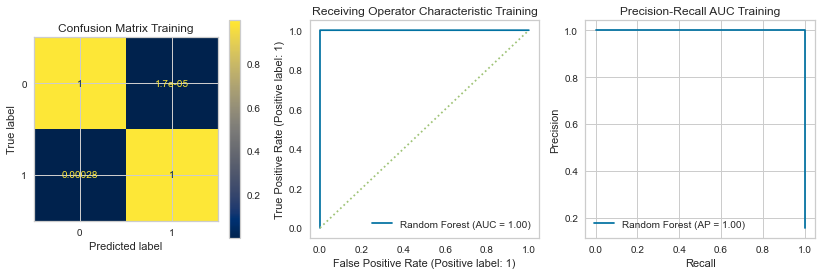

------------------------------------------------------------
Random Forest CLASSIFICATION REPORT TESTING 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      1.00      0.96     39113
           1       0.96      0.57      0.71      7165

    accuracy                           0.93     46278
   macro avg       0.94      0.78      0.84     46278
weighted avg       0.93      0.93      0.92     46278



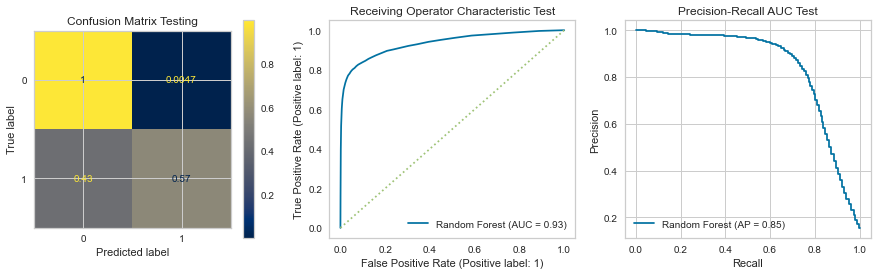

In [72]:
# classification report of our best performing model
final_model = evaluate_classification(rf_gs,
                        X_train, 
                        X_test, 
                        y_train, 
                        y_test, 
                        label='Random Forest')

***

Random forest classifier with default parameters is our best performing model with an AP score of: 85%. We started off with simpler models (logistic regression, decision tree) that did not perform as well despite applying grid search and modifying some parameters. Our data performed better with an ensemble classification which are known to to be effective in a wide range of problems. The gradient boost ensemble nor the random forest with SMOTE, performed better than the simple random forest. We also attempted a simple grid search on the random forest classifier. However, the grid search confirmed that the default parameters were set at the best performing settings. 

***

In [73]:
# saving as final model
import pickle
# saving model in folder for future use
# filename ends in '.pkl'
def save_model(model, filename):

    with open(filename, 'wb') as file:
        pickle.dump(model, file)
save_model(final_model, 'injury_prediction_model.pkl')

In [1]:
# final model with different metric

## Permutation Feature Importance

Feature selection is a process where you select those features in your data that contribute most to the prediction variable.

We will use permutation importance to evaluate the importance of the features. Permutation importance is calculated by the decrease in a model score when a single feature value is randomly shuffled. The decrease in the score suggests how much the model depends on the feature. Additionally, we specify the score function used to calculate the importance value to: average_precision_score. This feature selection will only reflect the importance value of the features relative to our selected best model: random forest classifier. [(scikit-learn)](https://scikit-learn.org/stable/modules/permutation_importance.html#permutation-importance)

In [74]:
# from sklearn documentation
# number of times a feature is randomly shuffled specified to: 30
features = permutation_importance(weighted_dt, 
                                 X_test, 
                                 y_test, 
                                 n_repeats=30, 
                                 scoring='average_precision', 
                                 random_state=42)

In [75]:
# from sklearn documentation
# probing which features are most predictive
for i in features.importances_mean.argsort()[::-1]:
     if features.importances_mean[i] - 2 * features.importances_std[i] > 0:
         print(f"{X_test.columns[i]:<8}"
               f"{features.importances_mean[i]:.3f}"
               f" +/- {features.importances_std[i]:.3f}")

FIRST_CRASH_TYPE0.389 +/- 0.004
LOCATION0.267 +/- 0.001
TRAFFICWAY_TYPE0.183 +/- 0.002
CRASH_MONTH0.107 +/- 0.002
CRASH_HOUR0.103 +/- 0.002
CRASH_DAY_OF_WEEK0.097 +/- 0.002
TRAFFIC_CONTROL_DEVICE0.086 +/- 0.002
DEVICE_CONDITION0.080 +/- 0.002
LIGHTING_CONDITION0.073 +/- 0.002
SPEED_LIMIT0.048 +/- 0.001
ROADWAY_SURFACE_COND0.043 +/- 0.001
WEATHER_CONDITION0.025 +/- 0.001
VEHICLE_TYPE0.015 +/- 0.001


Note that the importance values for the top two features represents a significant fraction of the feature score. 'FIRST_CRASH_TYPE' and 'LOCATION' make up nearly 67% of the score. We will focus on the five features with the highest importance values which will also include: 'TRAFFICWAY_TYPE', 'CRASH_MONTH', and 'CRASH_HOUR'. We are interpreting that these five features are most important for predicting whether an injury occurs in a crash incident.

## Conclusion

We built a classifier that predicts whether an injury occurs, or not, at a crash incident given publicly available crash report data about the incident, vehicles involved, and people involved.  
We can predict whether a crash incident would involve injury based on engineered features at an accuracy of 93% and have determined which of features are most important in predicting injury.
 1. 'FIRST_CRASH_TYPE': The type of a collision in a crash had an importance value of .389 in our final model.
  - Most incidents occured when turning or going at an angle. Most incidents with injury also occured when turning or going at an angle. 
  - From the EDA plots, we can see that while turning or going at an angle did have the most incidents with injury, the number of incidents with injury were present at a significatly higher ratio in incidents of pedestrian/cyclist type in comparison to the other crash type values.
  - Incidents where the front of the vehicle collided into the front or rear of the other vehicle were the second most likely to involve an injury even though it had the third most number of total incidents.
  - While in comparison to the other crash types, there were not as many total incidents involving a cyclist or pedestrian; unfortunately, most of the incidents involving a cyclist or pedestrian also involved an injury.
  
 2. 'LOCATION': The crash location had an importance value of .267 in our final model.
  - Most incidents occured in the location points of the O'Hare International Aiport, the [fourth-busiest](https://www.axios.com/local/chicago/2022/04/14/ohare-named-fourth-busiest-airport-in-the-world) airport in the world.
  - The second most incidents occured on South Lake Shore Dr., as it goes through Jackson park and paralell to two beaces. 
  - The third most incidents also occured on South Lake Shore Dr., but further south. This stretch of South Lake Shore Dr. also goes through a park and is parallel to a water front. 
  - The fourth most incidents ocurred at location points that seem busy. It is around the South Chicago Ave, South Stony Avenue, and E 79th Street intersections. On the map these streets appear like main wide streets. The is also a highway going over the busy intersention. Unsure whether the incidents occured on the highway or street intersection.
  - The fifth most incidents occured also on a South Stony Avenue intersection, this time crossing E 95th Street which is alsous 20 Highway. This intersection is also large on the map with at least 5 lanes in the intersections.
    
 3. 'TRAFFICWAY_TYPE': The type of trafficway where the crash incident took place had an importance value of .183 in our final model. 
  - Most incidents occured on trafficways that were not divided. Most incidents with injury also occured on trafficways that were not divided. 
  - The fourth most incidents occured on trafficways that are fourway. Moreover, it seems incidents with fourways had the largest proportion of incidents with injury.
  - We did not have enough information to determine the trafficway type for 7743 incidents.
  - Incidents that occured on trafficways that are one-way were fourth most likely to involve an injury even though it had the third most incidents. 
  - While the fifth most incidents occured in parking lots, some of the lower number of incidents with injury occured in parking lots.
  
 4. 'CRASH_MONTH': The month where the crash incident took place had an importance value of .107 in our final model. 
  - Most incidents occured in October. However, October seems to have the third most incidents with injury.
  - The second most incidents occured in July. However, the highest amount of incidents with injury occured in July.
  - The third most incidents occured in September. However, the second most amount of incidents with injury occured in September.
  - The ratio of incidents with injury and no injury seem to be pretty similar across all months.
 
 5. 'CRASH_HOUR': The time of day where the crash incident took place had an importance value of .103 in our final model. 
  - The most incidents occured at 3pm, followed by 4pm, then 5pm.. However, October seems to have the third most incidents with injury.
  - The graph seems to show that while there are significantly less incidents that occur in the late night hours, there seems to be a higher proportion of incidents with injury during those hours.
  - The five hour block where most incidents occured is from 2pm to 7pm. It seems the five hour block where the most incidents with injury occured is also from 2pm to 7pm.
  - More specifically, it seems the highest proportion of incidents with injury occur from 5pm to 9pm.
  - The most amount of incidents with injury occur from 1pm to 5pm, the time block where significantly more total incidents occur.
  - There seems to be a higher proportion of incidents with injury occuring from 12am to 5am.
  
  
  <img src="https://design.chicago.gov/assets/img/logo/LOGO-CHICAGO-horizontal.png" alt="Chicago logo" title="Chicago Logo" align = "center" width="150"/> 
  <img src="https://www.chicago.gov/content/dam/city/depts/cdot/CDOT%20Projects/VisionZero/VisionZeroLogo_Road_Horizontal_Long-01.png" alt="Vision Zero Chicago logo" title="Vision Zero Chicago Logo" align = "center" width="250"/>
  
 
### Predictive Recommendations
We, the Vision Zero initiative, are committed to working with the City of Chicago to eliminate fatalities and serious injuries from traffic crashes. Our recommendations for the City of Chicago are backed by data and focus on those features most likely to result in an injury given the city's limited resources. 
Vision Zero recommends the following: 
***
   - 'FIRST_CRASH_TYPE'
        - Since a crash incident is more likely to involve injury when a cyclist or pedestrian is involved, resources should support Public Health/Safety Campaigns that caution of the high injury rate in incidents where a cyclist or pedestrian is involved. Provide free helmets and bike lights, with information on importance of proper usage. Encourage bright clothing to cyclists and pedestrians particularly in lower visible settings. Give warning that vehicle traffic fees involving cyclists or pedestrians will increase if numbers do not decrease.
   - 'LOCATION'
        - Upgrade the traffic control devices and or include more warnings or traffic control officers along the top location points where the most incidents occur. 
        - Upgrade lanes and traffic signage around the top location points to be more cyclist and pedestrian friendly, including accessability considerations.
   - 'TRAFFICWAY_TYPE'
        - Upgrade the traffic control devices and or include more warnings or traffic control officers along the other problematic location points that are also of fourway trafficway type.
   - 'CRASH_MONTH' & 'CRASH_HOUR'
        - Traffic officers and paramedics should increase presence and/or resource availability in those top locations, particularly during the months of: July, September, and October and particularly during the hours of: 5pm to 9pm. 
        - Consider lowering public transportation fees during those months and/or hours and increasing number of trains/buses in rotation. This will encourage less vehicles on the roads which could decrease opportunities for crash incidents.  
***
By focusing resources on features most important in predicting injury, the City of Chicago can reduce the likelihood of injury from traffic crashes and improve the safety of streets for everyone.

## Next Steps

 - Better data collection could significantly improve our prediction ability. Unfortunately, features worthy of attention were dropped due to excessive nulls or unknowns. Age and sex are some features that were dropped due to having almost 90% null values. Weather and safety equipment are other possibly important features that were dropped to due to excessive nulls or unknowns.
 - Widen the crash date range to include crashes from more years.
 - Include new data as the chicago data portal is updated daily.
 - Conduct a more extensive grid search on random forest focusing on those parameters that can address our data imbalance like class weight.
 - Use feature importance to improve our predictive model, removing those features with lower scores. Reintroducing some of the deleted features to reevaluate their importance.
 - Use location points to create crash incident maps to identify if there are any top locations that cluster near each other for priority identification. 

<img src="https://www.chicago.gov/content/dam/city/cds/chicago.gov-logo.png" alt="Chicago logo" title="Chicago Logo" width="100"/>